In [ ]:
! pip install pytorch-lightning --quiet
! pip install lightning-bolts --quiet
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
from util import *
from pl_bolts import callbacks
from sklearn.metrics import classification_report
log_dir = "logistic_logs"

In [ ]:
ds = SeedDataset()
print(f'training_set size: {len(ds)}')
test_ds = SeedDataset(True)
print(f'testing_set size: {len(test_ds)}')

In [ ]:
target_names = ['class_1', 'class_2',
                'class_3', 'class_4', 'class_5',
                'class_6', 'class_7', 'class_8','class_9','class_0']



# Baseline model from sklearn

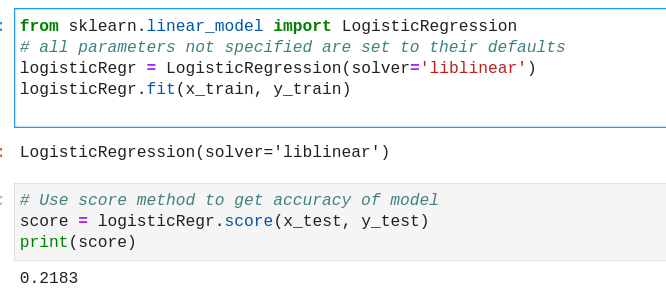

# Logistic Regression Model

In [ ]:
class LogisticRegression(LightningModule):
    def __init__(self,config,num_in = 28*28*1 ,num_class=10,):
        super().__init__()
        self.save_hyperparameters()
        self.layer_1 = nn.Linear(self.hparams.num_in,self.hparams.num_class)
        
        # Unfortunately we can’t (or at least shouldn’t) use the same cost function MSE (L2) as we did 
        # for linear regression. Why? There is a great math explanation in chapter 3 of Michael Neilson’s deep learning book [5],
        #  but for now I’ll simply say it’s because our prediction function is non-linear (due to sigmoid transform).
        #  Squaring this prediction as we do in MSE results in a non-convex function with many local minimums.
        #  If our cost function has many local minimums, gradient descent may not find the optimal global minimum.
        self.criterion = nn.CrossEntropyLoss()
        self.learned_weights = None

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = x.view(x.size(0), -1)
        output = self.layer_1(x)
        return output
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        loss = 0
        x, y = batch[0]
        logits = self.forward(x)

        # enable the auto confused logit callback
        self.last_batch = batch[0]
        self.last_logits = logits.detach()
        
        # print(f'logit.shape: {logits.shape}')
        # print(f'target.shape: {y.shape}')
        loss += self.criterion(logits, torch.squeeze(y,1))
        _, predicted = torch.max(logits, 1)
        # print(predicted)
        acc = accuracy(predicted,y)
        if(self.hparams.config['lambda_l1']):
            l1_norm = sum(p.abs().sum() for p in self.parameters())
            loss+=l1_norm * self.hparams.config['lambda_l1']
        # if(self.hparams.config['lambda_l2']):
        #     l2_norm = sum(p.pow(2.0).sum() for p in self.parameters())
        #     loss+=l2_norm * self.hparams.config['lambda_l2']
        self.log('train/loss', loss,on_step=False, on_epoch=True)
        self.log('train/acc',acc, on_step=False, on_epoch=True)
        if(batch_idx==0):
            x1,y1 = batch[1]
            with torch.no_grad():
                logits1 = self.forward(x1)
            self.logger.experiment.add_embedding(logits1, metadata=np.array(y1).tolist(),label_img=x1,global_step=self.current_epoch)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, torch.squeeze(y,1)) # this has softmax
        _, predicted = torch.max(logits, 1)
        acc = accuracy(predicted,y)
        return {"val_loss": loss, "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["val_accuracy"] for x in outputs]).mean()
        self.log("val/loss", avg_loss)
        self.log("val/accuracy", avg_acc)

    def test_step(self, batch, batch_idx):
        # validation_step defined the train loop.
        # It is independent of forward

        x, class_label = batch
        # print(x)
        # classfication loss
        logits = self.forward(x)
        score, predicted = torch.max(logits, 1)
        # print(f'predicted:{predicted.item()}, should be {class_label.item()}')
        acc = accuracy(predicted,class_label)
        
        return {"acc":acc,
                "pred":predicted,
                "label":class_label}

    def test_epoch_end(self,outputs):
        test_acc = torch.mean(
            torch.stack([x["acc"] for x in outputs]))
        self.test_acc=test_acc
        self.log("hp_metric",test_acc)
        preds = torch.stack([x["pred"] for x in outputs])
        targets = torch.stack([x["label"] for x in outputs])
        # fm = imshow_features(list(self.parameters()))
        # print(classification_report(y_test, res, target_names=target_names))
        # confusion_matrix = pl.metrics.functional.confusion_matrix(preds, targets, num_classes=10)
        # df_cm = pd.DataFrame(confusion_matrix.to("cpu").numpy(), index = range(10), columns=range(10))
        # plt.figure(figsize = (10,7))
        # fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        # plt.close(fig_)
        self.learned_weights = list(self.parameters())
        # self.logger.experiment.add_figure("Feature Map", fm, self.current_epoch)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.config['lr'],)
                                    # weight_decay=self.hparams.config["lambda_l2"] )
        return optimizer


In [ ]:
# training loop
# model_accuracy_logistic = list()
from pl_bolts.callbacks.vision.confused_logit import ConfusedLogitCallback
def train_model(config,num_epochs=3, num_gpus=0):
    assert config != None
    if(config['rgb']):
        m = LogisticRegression(config,num_in=32*32*3)
        logger = TensorBoardLogger(log_dir, name=config["name"])
    else:
        m = LogisticRegression(config)
        logger = TensorBoardLogger(log_dir, name=config["name"])
    confuse_callback = ConfusedLogitCallback(top_k=3,logging_batch_interval=1,min_logit_value=3.0)
    trainer = Trainer(max_epochs=num_epochs, progress_bar_refresh_rate=20,
                      fast_dev_run=False,
                      gpus=num_gpus,
#                       callbacks=[confuse_callback],
                      logger=logger)
    dm = SVHNDataModule(batch_size=config['batch_size'],rgb=config['rgb'])
    trainer.fit(m,dm)
    # trainer.test(m,datamodule=dm)
    return m.learned_weights
    # results= m.test_acc
    # model_accuracy_logistic.append(results)

config_rgb = {
    'lr':1e-3,
    'batch_size':32,
    'lambda_l2':1e-5,
    'lambda_l1':None,
    'name':"single",
    "rgb":False
}



w1 = train_model(config_rgb,4)


# Tensorflow board

In [ ]:
# !kill 287
%load_ext tensorboard
%tensorboard --logdir "$log_dir"